In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import rasterio as io




import torch.nn.functional as F



import matplotlib.pyplot as plt
from torch.optim import Optimizer
from torch.nn import Module
from torch.cuda import device as cuda_device
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss
from sklearn.metrics import r2_score
import numpy as np

In [2]:
# # Check if CUDA is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f'Running on device: {device}')

In [2]:
img_train = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/combined_images/train_2"
img_val = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/combined_images/val_2"
img_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/combined_images/test2"



crop_train = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/combined_images/train_2/normalized_train_yield.csv"
crop_val = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/combined_images/val_2/normalized_val_yield.csv"
crop_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/combined_images/test2/normalized_test_yield.csv"





In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    # transforms.ConvertImageDtype(torch.float64)  # Convert input data to double precision
])

In [4]:
# Define dataset class
class CropYieldDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None, mode='train'):
        self.img_dir = img_dir
        self.csv_data = pd.read_csv(csv_file)
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.csv_data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.csv_data.iloc[idx, 1] + ".tif")
        with io.open(img_name) as src:
            image = src.read().astype('float64')  # Read image as float64
        soy_yield_normalized= self.csv_data.iloc[idx, 6]  # First crop yield value
        corn_yield_normalized = self.csv_data.iloc[idx, 7]  # Second crop yield value
        
        if self.transform:
            # image = self.transform(image)
            p=5
        if self.mode == 'test':
            return image, (corn_yield_normalized, soy_yield_normalized)
        else:
            return image,(torch.tensor(corn_yield_normalized, dtype=torch.float64), torch.tensor(soy_yield_normalized, dtype=torch.float64))

In [5]:
dataset_train = CropYieldDataset(img_dir=img_train, csv_file=crop_train, transform=transform)
dataset_val = CropYieldDataset(img_dir=img_val, csv_file=crop_val, transform=transform)
dataset_test = CropYieldDataset(img_dir=img_test, csv_file=crop_test, transform=transform)


In [6]:
# Move data loaders to GPU
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=True, pin_memory=True)
# train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=4, collate_fn=None)
# val_loader = DataLoader(dataset_val, batch_size=4, shuffle=False, num_workers=4, collate_fn=None)


In [8]:
# for i ,name,l in train_loader:
#     print(i.shape)
#     print(l)
#     # print(i)
#     print(name)
#     break

In [9]:
# train_loader.dataset[10]

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNRegressor(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(9, 128, kernel_size=3, padding=1)  # Input channels changed to 9
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

        # Define the MaxPooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the flattened features after all conv and pooling layers
        # Pooling layer applied four times, each halves both dimensions: 224 -> 112 -> 56 -> 28 -> 14
        final_dimension = 14  # this is what 224 / 2 / 2 / 2 / 2 evaluates to

        # Define the BatchNormalization for the fully connected layer
        self.batch_norm = nn.BatchNorm1d(64)

        # Define the fully connected layers
        self.fc1 = nn.Linear(32 * final_dimension * final_dimension, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 4)
        
        # Define two separate heads for the output
        self.head1 = nn.Linear(4, 1)
        self.head2 = nn.Linear(4, 1)

        # Define dropout layer
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Apply convolutions and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        # Flatten the output for the dense layers
        x = torch.flatten(x, 1)

        # Apply dense layers with ReLU and dropout
        x = F.relu(self.batch_norm(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))

        # Apply the two separate output heads
        # out1 = self.sigmoid(self.head1(x))
        # out2 = self.sigmoid(self.head2(x))

        out1 = self.head1(x)
        out2 = self.head2(x)
        
        # Concatenate the outputs from the two heads
        output = torch.cat((out1, out2), dim=1)

        return output




In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import numpy as np
import os
from tqdm import tqdm
from torch.utils.data import Dataset
import pandas as pd
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Assuming CNNRegressor, train_loader, val_loader, and other necessary elements are defined


class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.counter = 0
        self.checkpoint_dir = 'checkpoints_CNN_combined_No_segmoid'

        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)

    def __call__(self, val_loss, model, optimizer, epoch):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer, epoch):
        """Saves model and optimizer when validation loss decreases."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        checkpoint_path = os.path.join(self.checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss
        }, checkpoint_path)
        self.val_loss_min = val_loss

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss1 = 0.0
    running_loss2 = 0.0
    all_outputs = []
    all_labels = []

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), torch.stack(labels, dim=1).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss1 = criterion(outputs[:, 0], labels[:, 0])
        loss2 = criterion(outputs[:, 1], labels[:, 1])
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        running_loss1 += loss1.item() * images.size(0)
        running_loss2 += loss2.item() * images.size(0)
        all_outputs.append(outputs.detach().cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    all_outputs = np.vstack(all_outputs)
    all_labels = np.vstack(all_labels)
    train_r2_score1 = r2_score(all_labels[:, 0], all_outputs[:, 0])
    train_r2_score2 = r2_score(all_labels[:, 1], all_outputs[:, 1])

    epoch_loss1 = running_loss1 / len(train_loader.dataset)
    epoch_loss2 = running_loss2 / len(train_loader.dataset)
    total_epoch_loss = epoch_loss1 + epoch_loss2

    return epoch_loss1, epoch_loss2, total_epoch_loss, (train_r2_score1, train_r2_score2)

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss1 = 0.0
    val_loss2 = 0.0
    all_val_outputs = []
    all_val_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), torch.stack(labels, dim=1).to(device)
            outputs = model(images)
            loss1 = criterion(outputs[:, 0], labels[:, 0])
            loss2 = criterion(outputs[:, 1], labels[:, 1])
            val_loss1 += loss1.item() * images.size(0)
            val_loss2 += loss2.item() * images.size(0)
            all_val_outputs.append(outputs.detach().cpu().numpy())
            all_val_labels.append(labels.cpu().numpy())

    all_val_outputs = np.vstack(all_val_outputs)
    all_val_labels = np.vstack(all_val_labels)
    val_r2_score1 = r2_score(all_val_labels[:, 0], all_val_outputs[:, 0])
    val_r2_score2 = r2_score(all_val_labels[:, 1], all_val_outputs[:, 1])

    val_loss1 /= len(val_loader.dataset)
    val_loss2 /= len(val_loader.dataset)
    total_val_loss = val_loss1 + val_loss2

    return val_loss1, val_loss2, total_val_loss, (val_r2_score1, val_r2_score2)

def plot_metrics(train_losses1, train_losses2, val_losses1, val_losses2, train_r2_scores1, train_r2_scores2, val_r2_scores1, val_r2_scores2, num_epochs,base_dir):
    epochs = range(1, num_epochs + 1)
    base_dir = base_dir
    # Plot loss (Corn)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses1, 'b-', label='Training loss (Corn)')
    plt.plot(epochs, val_losses1, 'r-', label='Validation loss (Corn)')
    plt.xlabel('Epochs')
    plt.ylabel('loss (Corn)')
    plt.legend()
    plt.title('Training and Validation loss (Corn)')
    
    plt.savefig(os.path.join(base_dir, 'loss_corn.png'))
    plt.show()
    
    # Plot Loss (Soybeans)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses2, 'b--', label='Training Loss (Soybeans)')
    plt.plot(epochs, val_losses2, 'r--', label='Validation Loss (Soybeans)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Soybeans)')
    plt.legend()
    plt.title('Training and Validation Loss (Soybeans)')
    
    plt.savefig(os.path.join(base_dir, 'loss_soybean.png'))
    plt.show()
    
    # Plot R² Score (Corn)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_r2_scores1, 'b-', label='Training R² Score (Corn)')
    plt.plot(epochs, val_r2_scores1, 'r-', label='Validation R² Score (Corn)')
    plt.xlabel('Epochs')
    plt.ylabel('R² Score (Corn)')
    plt.legend()
    plt.title('Training and Validation R² Score (Corn)')
    
    plt.savefig(os.path.join(base_dir, 'r2_score_corn.png'))
    plt.show()
    
    # Plot R² Score (Soybeans)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_r2_scores2, 'b--', label='Training R² Score (Soybeans)')
    plt.plot(epochs, val_r2_scores2, 'r--', label='Validation R² Score (Soybeans)')
    plt.xlabel('Epochs')
    plt.ylabel('R² Score (Soybeans)')
    plt.legend()
    plt.title('Training and Validation R² Score (Soybeans)')
 
    plt.savefig(os.path.join(base_dir, 'r2_score_soybean.png'))
    plt.show()



base_dir = 'checkpoints_CNN_combined_No_segmoid'
num_epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNRegressor().double()
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Initialize learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

early_stopper = EarlyStopping(patience=10, verbose=True)


train_losses1, train_losses2, train_losses = [], [], []
val_losses1, val_losses2, val_losses = [],[],[]
train_r2_scores1, train_r2_scores2 = [], []
val_r2_scores1, val_r2_scores2 = [],[]

with open(os.path.join(base_dir, 'loss_log_CNN_combined_No_sigmoid.txt'), 'w') as f:
    f.write("Epoch,Training Loss 1,Training Loss 2,Total Training Loss,Training R^2 Score 1,Training R^2 Score (Soybeans),Validation Loss 1,Validation Loss 2,Total Validation Loss,Validation R^2 Score 1,Validation R^2 Score 2,Learning Rate\n")

    for epoch in range(num_epochs):
        try:
            train_loss1, train_loss2, train_loss, train_r2 = train_one_epoch(model, train_loader, criterion, optimizer, device)
            val_loss1, val_loss2, val_loss, val_r2 = validate_one_epoch(model, val_loader, criterion, device)

            train_losses1.append(train_loss1)
            train_losses2.append(train_loss2)
            train_losses.append(train_loss)
            val_losses1.append(val_loss1)
            val_losses2.append(val_loss2)
            val_losses.append(val_loss)
            train_r2_scores1.append(train_r2[0])
            train_r2_scores2.append(train_r2[1])
            val_r2_scores1.append(val_r2[0])
            val_r2_scores2.append(val_r2[1])

            # Get current learning rate
            current_lr = optimizer.param_groups[0]['lr']

            f.write(f"{epoch + 1},{train_loss1:.4f},{train_loss2:.4f},{train_loss:.4f},{train_r2[0]:.4f},{train_r2[1]:.4f},{val_loss1:.4f},{val_loss2:.4f},{val_loss:.4f},{val_r2[0]:.4f},{val_r2[1]:.4f},{current_lr:.6f}\n")

            print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss (Corn): {train_loss1:.4f}, Training Loss (Soybeans): {train_loss2:.4f}, Total Training Loss: {train_loss:.4f}, Training R^2 Score  (Corn): {train_r2[0]:.4f}, Training R^2 Score (Soybeans): {train_r2[1]:.4f}")
            print(f"Validation Loss (Corn): {val_loss1:.4f}, Validation Loss (Soybeans): {val_loss2:.4f}, Total Validation Loss: {val_loss:.4f}, Validation R^2 Score  (Corn): {val_r2[0]:.4f}, Validation R^2 Score (Soybeans): {val_r2[1]:.4f}")
            print(f"Learning Rate: {current_lr:.6f}")

            early_stopper.save_checkpoint(val_loss, model, optimizer, epoch)
            early_stopper(val_loss, model, optimizer, epoch)
            
            # Step the scheduler
            scheduler.step(val_loss)

            if early_stopper.early_stop:
                print("Early stopping triggered.")
                break
        except Exception as e:
            print(f"Exception occurred: {e}")
            early_stopper.save_checkpoint(val_loss, model, optimizer, epoch)
            break

    
    # Plot the metrics



Validation: 100%|██████████| 74/74 [00:47<00:00,  1.57it/s]


Epoch [1/50], Training Loss (Corn): 0.1614, Training Loss (Soybeans): 0.0364, Total Training Loss: 0.1979, Training R^2 Score  (Corn): -2.8504, Training R^2 Score (Soybeans): -0.1036
Validation Loss (Corn): 0.1397, Validation Loss (Soybeans): 0.0341, Total Validation Loss: 0.1737, Validation R^2 Score  (Corn): -2.3213, Validation R^2 Score (Soybeans): -0.0133
Learning Rate: 0.000100
Validation loss decreased (inf --> 0.173742). Saving model ...
Validation loss decreased (0.173742 --> 0.173742). Saving model ...


Validation: 100%|██████████| 74/74 [00:47<00:00,  1.56it/s]


Epoch [2/50], Training Loss (Corn): 0.1343, Training Loss (Soybeans): 0.0334, Total Training Loss: 0.1676, Training R^2 Score  (Corn): -2.2023, Training R^2 Score (Soybeans): -0.0109
Validation Loss (Corn): 0.1296, Validation Loss (Soybeans): 0.0337, Total Validation Loss: 0.1633, Validation R^2 Score  (Corn): -2.0814, Validation R^2 Score (Soybeans): -0.0028
Learning Rate: 0.000100
Validation loss decreased (0.173742 --> 0.163299). Saving model ...
Validation loss decreased (0.163299 --> 0.163299). Saving model ...


Validation: 100%|██████████| 74/74 [00:45<00:00,  1.62it/s]


Epoch [3/50], Training Loss (Corn): 0.1245, Training Loss (Soybeans): 0.0332, Total Training Loss: 0.1576, Training R^2 Score  (Corn): -1.9691, Training R^2 Score (Soybeans): -0.0043
Validation Loss (Corn): 0.1207, Validation Loss (Soybeans): 0.0336, Total Validation Loss: 0.1544, Validation R^2 Score  (Corn): -1.8704, Validation R^2 Score (Soybeans): -0.0007
Learning Rate: 0.000100
Validation loss decreased (0.163299 --> 0.154357). Saving model ...
Validation loss decreased (0.154357 --> 0.154357). Saving model ...


Validation: 100%|██████████| 74/74 [00:46<00:00,  1.59it/s]


Epoch [4/50], Training Loss (Corn): 0.1158, Training Loss (Soybeans): 0.0331, Total Training Loss: 0.1489, Training R^2 Score  (Corn): -1.7629, Training R^2 Score (Soybeans): -0.0017
Validation Loss (Corn): 0.1124, Validation Loss (Soybeans): 0.0336, Total Validation Loss: 0.1460, Validation R^2 Score  (Corn): -1.6730, Validation R^2 Score (Soybeans): 0.0001
Learning Rate: 0.000100
Validation loss decreased (0.154357 --> 0.146022). Saving model ...
Validation loss decreased (0.146022 --> 0.146022). Saving model ...


Validation: 100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


Epoch [5/50], Training Loss (Corn): 0.1079, Training Loss (Soybeans): 0.0330, Total Training Loss: 0.1409, Training R^2 Score  (Corn): -1.5728, Training R^2 Score (Soybeans): -0.0002
Validation Loss (Corn): 0.1047, Validation Loss (Soybeans): 0.0336, Total Validation Loss: 0.1383, Validation R^2 Score  (Corn): -1.4905, Validation R^2 Score (Soybeans): 0.0001
Learning Rate: 0.000100
Validation loss decreased (0.146022 --> 0.138349). Saving model ...
Validation loss decreased (0.138349 --> 0.138349). Saving model ...


Validation: 100%|██████████| 74/74 [00:47<00:00,  1.56it/s]


Epoch [6/50], Training Loss (Corn): 0.1005, Training Loss (Soybeans): 0.0330, Total Training Loss: 0.1335, Training R^2 Score  (Corn): -1.3977, Training R^2 Score (Soybeans): 0.0006
Validation Loss (Corn): 0.0976, Validation Loss (Soybeans): 0.0336, Total Validation Loss: 0.1312, Validation R^2 Score  (Corn): -1.3216, Validation R^2 Score (Soybeans): 0.0004
Learning Rate: 0.000100
Validation loss decreased (0.138349 --> 0.131237). Saving model ...
Validation loss decreased (0.131237 --> 0.131237). Saving model ...


Validation: 100%|██████████| 74/74 [00:45<00:00,  1.61it/s]


Epoch [7/50], Training Loss (Corn): 0.0938, Training Loss (Soybeans): 0.0330, Total Training Loss: 0.1268, Training R^2 Score  (Corn): -1.2368, Training R^2 Score (Soybeans): 0.0012
Validation Loss (Corn): 0.0912, Validation Loss (Soybeans): 0.0336, Total Validation Loss: 0.1248, Validation R^2 Score  (Corn): -1.1679, Validation R^2 Score (Soybeans): 0.0002
Learning Rate: 0.000100
Validation loss decreased (0.131237 --> 0.124777). Saving model ...
Validation loss decreased (0.124777 --> 0.124777). Saving model ...


Validation: 100%|██████████| 74/74 [00:45<00:00,  1.61it/s]


Epoch [8/50], Training Loss (Corn): 0.0877, Training Loss (Soybeans): 0.0328, Total Training Loss: 0.1205, Training R^2 Score  (Corn): -1.0910, Training R^2 Score (Soybeans): 0.0054
Validation Loss (Corn): 0.0856, Validation Loss (Soybeans): 0.0332, Total Validation Loss: 0.1188, Validation R^2 Score  (Corn): -1.0348, Validation R^2 Score (Soybeans): 0.0121
Learning Rate: 0.000100
Validation loss decreased (0.124777 --> 0.118780). Saving model ...
Validation loss decreased (0.118780 --> 0.118780). Saving model ...


Validation: 100%|██████████| 74/74 [00:45<00:00,  1.62it/s]


Epoch [9/50], Training Loss (Corn): 0.0821, Training Loss (Soybeans): 0.0327, Total Training Loss: 0.1147, Training R^2 Score  (Corn): -0.9578, Training R^2 Score (Soybeans): 0.0111
Validation Loss (Corn): 0.0823, Validation Loss (Soybeans): 0.0316, Total Validation Loss: 0.1139, Validation R^2 Score  (Corn): -0.9568, Validation R^2 Score (Soybeans): 0.0583
Learning Rate: 0.000100
Validation loss decreased (0.118780 --> 0.113946). Saving model ...
Validation loss decreased (0.113946 --> 0.113946). Saving model ...


Validation: 100%|██████████| 74/74 [00:45<00:00,  1.61it/s]


Epoch [10/50], Training Loss (Corn): 0.0771, Training Loss (Soybeans): 0.0323, Total Training Loss: 0.1094, Training R^2 Score  (Corn): -0.8379, Training R^2 Score (Soybeans): 0.0205
Validation Loss (Corn): 0.0753, Validation Loss (Soybeans): 0.0325, Total Validation Loss: 0.1078, Validation R^2 Score  (Corn): -0.7911, Validation R^2 Score (Soybeans): 0.0325
Learning Rate: 0.000100
Validation loss decreased (0.113946 --> 0.107847). Saving model ...
Validation loss decreased (0.107847 --> 0.107847). Saving model ...


Validation: 100%|██████████| 74/74 [00:46<00:00,  1.59it/s]


Epoch [11/50], Training Loss (Corn): 0.0725, Training Loss (Soybeans): 0.0320, Total Training Loss: 0.1045, Training R^2 Score  (Corn): -0.7285, Training R^2 Score (Soybeans): 0.0305
Validation Loss (Corn): 0.0713, Validation Loss (Soybeans): 0.0319, Total Validation Loss: 0.1032, Validation R^2 Score  (Corn): -0.6943, Validation R^2 Score (Soybeans): 0.0505
Learning Rate: 0.000100
Validation loss decreased (0.107847 --> 0.103171). Saving model ...
Validation loss decreased (0.103171 --> 0.103171). Saving model ...


Validation: 100%|██████████| 74/74 [00:46<00:00,  1.58it/s]


Epoch [12/50], Training Loss (Corn): 0.0682, Training Loss (Soybeans): 0.0317, Total Training Loss: 0.0999, Training R^2 Score  (Corn): -0.6269, Training R^2 Score (Soybeans): 0.0402
Validation Loss (Corn): 0.0665, Validation Loss (Soybeans): 0.0321, Total Validation Loss: 0.0986, Validation R^2 Score  (Corn): -0.5822, Validation R^2 Score (Soybeans): 0.0456
Learning Rate: 0.000100
Validation loss decreased (0.103171 --> 0.098617). Saving model ...
Validation loss decreased (0.098617 --> 0.098617). Saving model ...


Validation: 100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


Epoch [13/50], Training Loss (Corn): 0.0644, Training Loss (Soybeans): 0.0313, Total Training Loss: 0.0957, Training R^2 Score  (Corn): -0.5368, Training R^2 Score (Soybeans): 0.0530
Validation Loss (Corn): 0.0642, Validation Loss (Soybeans): 0.0306, Total Validation Loss: 0.0948, Validation R^2 Score  (Corn): -0.5256, Validation R^2 Score (Soybeans): 0.0897
Learning Rate: 0.000100
Validation loss decreased (0.098617 --> 0.094756). Saving model ...
Validation loss decreased (0.094756 --> 0.094756). Saving model ...


Validation: 100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


Epoch [14/50], Training Loss (Corn): 0.0609, Training Loss (Soybeans): 0.0307, Total Training Loss: 0.0916, Training R^2 Score  (Corn): -0.4519, Training R^2 Score (Soybeans): 0.0693
Validation Loss (Corn): 0.0584, Validation Loss (Soybeans): 0.0321, Total Validation Loss: 0.0905, Validation R^2 Score  (Corn): -0.3887, Validation R^2 Score (Soybeans): 0.0442
Learning Rate: 0.000100
Validation loss decreased (0.094756 --> 0.090529). Saving model ...
Validation loss decreased (0.090529 --> 0.090529). Saving model ...


Validation: 100%|██████████| 74/74 [00:46<00:00,  1.58it/s]


Epoch [15/50], Training Loss (Corn): 0.0570, Training Loss (Soybeans): 0.0305, Total Training Loss: 0.0875, Training R^2 Score  (Corn): -0.3591, Training R^2 Score (Soybeans): 0.0769
Validation Loss (Corn): 0.0564, Validation Loss (Soybeans): 0.0295, Total Validation Loss: 0.0860, Validation R^2 Score  (Corn): -0.3421, Validation R^2 Score (Soybeans): 0.1217
Learning Rate: 0.000100
Validation loss decreased (0.090529 --> 0.085963). Saving model ...
Validation loss decreased (0.085963 --> 0.085963). Saving model ...


Validation: 100%|██████████| 74/74 [00:46<00:00,  1.59it/s]


Epoch [16/50], Training Loss (Corn): 0.0529, Training Loss (Soybeans): 0.0301, Total Training Loss: 0.0830, Training R^2 Score  (Corn): -0.2625, Training R^2 Score (Soybeans): 0.0885
Validation Loss (Corn): 0.0491, Validation Loss (Soybeans): 0.0332, Total Validation Loss: 0.0823, Validation R^2 Score  (Corn): -0.1679, Validation R^2 Score (Soybeans): 0.0120
Learning Rate: 0.000100
Validation loss decreased (0.085963 --> 0.082324). Saving model ...
Validation loss decreased (0.082324 --> 0.082324). Saving model ...


Validation: 100%|██████████| 74/74 [00:46<00:00,  1.61it/s]


Epoch [17/50], Training Loss (Corn): 0.0490, Training Loss (Soybeans): 0.0290, Total Training Loss: 0.0780, Training R^2 Score  (Corn): -0.1677, Training R^2 Score (Soybeans): 0.1211
Validation Loss (Corn): 0.0476, Validation Loss (Soybeans): 0.0281, Total Validation Loss: 0.0757, Validation R^2 Score  (Corn): -0.1320, Validation R^2 Score (Soybeans): 0.1628
Learning Rate: 0.000100
Validation loss decreased (0.082324 --> 0.075747). Saving model ...
Validation loss decreased (0.075747 --> 0.075747). Saving model ...


Validation: 100%|██████████| 74/74 [00:46<00:00,  1.61it/s]


Epoch [18/50], Training Loss (Corn): 0.0453, Training Loss (Soybeans): 0.0272, Total Training Loss: 0.0725, Training R^2 Score  (Corn): -0.0811, Training R^2 Score (Soybeans): 0.1764
Validation Loss (Corn): 0.0455, Validation Loss (Soybeans): 0.0255, Total Validation Loss: 0.0709, Validation R^2 Score  (Corn): -0.0808, Validation R^2 Score (Soybeans): 0.2415
Learning Rate: 0.000100
Validation loss decreased (0.075747 --> 0.070946). Saving model ...
Validation loss decreased (0.070946 --> 0.070946). Saving model ...


Validation: 100%|██████████| 74/74 [00:47<00:00,  1.57it/s]


Epoch [19/50], Training Loss (Corn): 0.0423, Training Loss (Soybeans): 0.0247, Total Training Loss: 0.0669, Training R^2 Score  (Corn): -0.0079, Training R^2 Score (Soybeans): 0.2523
Validation Loss (Corn): 0.0389, Validation Loss (Soybeans): 0.0273, Total Validation Loss: 0.0662, Validation R^2 Score  (Corn): 0.0750, Validation R^2 Score (Soybeans): 0.1878
Learning Rate: 0.000100
Validation loss decreased (0.070946 --> 0.066201). Saving model ...
Validation loss decreased (0.066201 --> 0.066201). Saving model ...


Validation: 100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


Epoch [20/50], Training Loss (Corn): 0.0397, Training Loss (Soybeans): 0.0206, Total Training Loss: 0.0602, Training R^2 Score  (Corn): 0.0535, Training R^2 Score (Soybeans): 0.3774
Validation Loss (Corn): 0.0376, Validation Loss (Soybeans): 0.0187, Total Validation Loss: 0.0563, Validation R^2 Score  (Corn): 0.1070, Validation R^2 Score (Soybeans): 0.4427
Learning Rate: 0.000100
Validation loss decreased (0.066201 --> 0.056288). Saving model ...
Validation loss decreased (0.056288 --> 0.056288). Saving model ...


Validation: 100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


Epoch [21/50], Training Loss (Corn): 0.0376, Training Loss (Soybeans): 0.0154, Total Training Loss: 0.0530, Training R^2 Score  (Corn): 0.1025, Training R^2 Score (Soybeans): 0.5336
Validation Loss (Corn): 0.0379, Validation Loss (Soybeans): 0.0112, Total Validation Loss: 0.0490, Validation R^2 Score  (Corn): 0.0990, Validation R^2 Score (Soybeans): 0.6682
Learning Rate: 0.000100
Validation loss decreased (0.056288 --> 0.049045). Saving model ...
Validation loss decreased (0.049045 --> 0.049045). Saving model ...


Validation: 100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


Epoch [22/50], Training Loss (Corn): 0.0348, Training Loss (Soybeans): 0.0122, Total Training Loss: 0.0470, Training R^2 Score  (Corn): 0.1706, Training R^2 Score (Soybeans): 0.6298
Validation Loss (Corn): 0.0310, Validation Loss (Soybeans): 0.0186, Total Validation Loss: 0.0496, Validation R^2 Score  (Corn): 0.2631, Validation R^2 Score (Soybeans): 0.4467
Learning Rate: 0.000100
Validation loss decreased (0.049045 --> 0.049589). Saving model ...
EarlyStopping counter: 1 out of 10


Validation: 100%|██████████| 74/74 [00:47<00:00,  1.56it/s]


Epoch [23/50], Training Loss (Corn): 0.0319, Training Loss (Soybeans): 0.0102, Total Training Loss: 0.0421, Training R^2 Score  (Corn): 0.2393, Training R^2 Score (Soybeans): 0.6915
Validation Loss (Corn): 0.0292, Validation Loss (Soybeans): 0.0102, Total Validation Loss: 0.0395, Validation R^2 Score  (Corn): 0.3047, Validation R^2 Score (Soybeans): 0.6961
Learning Rate: 0.000100
Validation loss decreased (0.049589 --> 0.039457). Saving model ...
Validation loss decreased (0.039457 --> 0.039457). Saving model ...


Validation: 100%|██████████| 74/74 [00:48<00:00,  1.53it/s]


Epoch [24/50], Training Loss (Corn): 0.0293, Training Loss (Soybeans): 0.0087, Total Training Loss: 0.0381, Training R^2 Score  (Corn): 0.3005, Training R^2 Score (Soybeans): 0.7352
Validation Loss (Corn): 0.0284, Validation Loss (Soybeans): 0.0060, Total Validation Loss: 0.0344, Validation R^2 Score  (Corn): 0.3243, Validation R^2 Score (Soybeans): 0.8217
Learning Rate: 0.000100
Validation loss decreased (0.039457 --> 0.034409). Saving model ...
Validation loss decreased (0.034409 --> 0.034409). Saving model ...


Validation: 100%|██████████| 74/74 [00:46<00:00,  1.58it/s]


Epoch [25/50], Training Loss (Corn): 0.0255, Training Loss (Soybeans): 0.0074, Total Training Loss: 0.0329, Training R^2 Score  (Corn): 0.3914, Training R^2 Score (Soybeans): 0.7753
Validation Loss (Corn): 0.0206, Validation Loss (Soybeans): 0.0058, Total Validation Loss: 0.0264, Validation R^2 Score  (Corn): 0.5103, Validation R^2 Score (Soybeans): 0.8275
Learning Rate: 0.000100
Validation loss decreased (0.034409 --> 0.026394). Saving model ...
Validation loss decreased (0.026394 --> 0.026394). Saving model ...


Validation: 100%|██████████| 74/74 [00:47<00:00,  1.56it/s]


Epoch [26/50], Training Loss (Corn): 0.0115, Training Loss (Soybeans): 0.0069, Total Training Loss: 0.0184, Training R^2 Score  (Corn): 0.7263, Training R^2 Score (Soybeans): 0.7898
Validation Loss (Corn): 0.0060, Validation Loss (Soybeans): 0.0061, Total Validation Loss: 0.0121, Validation R^2 Score  (Corn): 0.8564, Validation R^2 Score (Soybeans): 0.8196
Learning Rate: 0.000100
Validation loss decreased (0.026394 --> 0.012104). Saving model ...
Validation loss decreased (0.012104 --> 0.012104). Saving model ...


Validation: 100%|██████████| 74/74 [00:51<00:00,  1.43it/s]


Epoch [27/50], Training Loss (Corn): 0.0058, Training Loss (Soybeans): 0.0057, Total Training Loss: 0.0115, Training R^2 Score  (Corn): 0.8615, Training R^2 Score (Soybeans): 0.8282
Validation Loss (Corn): 0.0051, Validation Loss (Soybeans): 0.0044, Total Validation Loss: 0.0095, Validation R^2 Score  (Corn): 0.8787, Validation R^2 Score (Soybeans): 0.8698
Learning Rate: 0.000100
Validation loss decreased (0.012104 --> 0.009479). Saving model ...
Validation loss decreased (0.009479 --> 0.009479). Saving model ...


Validation: 100%|██████████| 74/74 [00:47<00:00,  1.56it/s]


Epoch [28/50], Training Loss (Corn): 0.0054, Training Loss (Soybeans): 0.0052, Total Training Loss: 0.0107, Training R^2 Score  (Corn): 0.8704, Training R^2 Score (Soybeans): 0.8415
Validation Loss (Corn): 0.0049, Validation Loss (Soybeans): 0.0056, Total Validation Loss: 0.0106, Validation R^2 Score  (Corn): 0.8827, Validation R^2 Score (Soybeans): 0.8322
Learning Rate: 0.000100
Validation loss decreased (0.009479 --> 0.010573). Saving model ...
EarlyStopping counter: 1 out of 10


Validation: 100%|██████████| 74/74 [00:47<00:00,  1.55it/s]


Epoch [29/50], Training Loss (Corn): 0.0053, Training Loss (Soybeans): 0.0046, Total Training Loss: 0.0098, Training R^2 Score  (Corn): 0.8743, Training R^2 Score (Soybeans): 0.8616
Validation Loss (Corn): 0.0031, Validation Loss (Soybeans): 0.0031, Total Validation Loss: 0.0062, Validation R^2 Score  (Corn): 0.9260, Validation R^2 Score (Soybeans): 0.9072
Learning Rate: 0.000100
Validation loss decreased (0.010573 --> 0.006230). Saving model ...
Validation loss decreased (0.006230 --> 0.006230). Saving model ...


Validation: 100%|██████████| 74/74 [00:48<00:00,  1.54it/s]


Epoch [30/50], Training Loss (Corn): 0.0050, Training Loss (Soybeans): 0.0041, Total Training Loss: 0.0092, Training R^2 Score  (Corn): 0.8799, Training R^2 Score (Soybeans): 0.8750
Validation Loss (Corn): 0.0038, Validation Loss (Soybeans): 0.0040, Total Validation Loss: 0.0078, Validation R^2 Score  (Corn): 0.9098, Validation R^2 Score (Soybeans): 0.8800
Learning Rate: 0.000100
Validation loss decreased (0.006230 --> 0.007827). Saving model ...
EarlyStopping counter: 1 out of 10


Validation: 100%|██████████| 74/74 [00:47<00:00,  1.54it/s]


Epoch [31/50], Training Loss (Corn): 0.0051, Training Loss (Soybeans): 0.0040, Total Training Loss: 0.0092, Training R^2 Score  (Corn): 0.8776, Training R^2 Score (Soybeans): 0.8778
Validation Loss (Corn): 0.0026, Validation Loss (Soybeans): 0.0015, Total Validation Loss: 0.0042, Validation R^2 Score  (Corn): 0.9372, Validation R^2 Score (Soybeans): 0.9545
Learning Rate: 0.000100
Validation loss decreased (0.007827 --> 0.004170). Saving model ...
Validation loss decreased (0.004170 --> 0.004170). Saving model ...


Validation: 100%|██████████| 74/74 [00:47<00:00,  1.56it/s]


Epoch [32/50], Training Loss (Corn): 0.0047, Training Loss (Soybeans): 0.0038, Total Training Loss: 0.0086, Training R^2 Score  (Corn): 0.8869, Training R^2 Score (Soybeans): 0.8843
Validation Loss (Corn): 0.0041, Validation Loss (Soybeans): 0.0027, Total Validation Loss: 0.0068, Validation R^2 Score  (Corn): 0.9028, Validation R^2 Score (Soybeans): 0.9186
Learning Rate: 0.000100
Validation loss decreased (0.004170 --> 0.006825). Saving model ...
EarlyStopping counter: 1 out of 10


Validation: 100%|██████████| 74/74 [00:46<00:00,  1.58it/s]


Epoch [33/50], Training Loss (Corn): 0.0046, Training Loss (Soybeans): 0.0037, Total Training Loss: 0.0083, Training R^2 Score  (Corn): 0.8894, Training R^2 Score (Soybeans): 0.8878
Validation Loss (Corn): 0.0027, Validation Loss (Soybeans): 0.0018, Total Validation Loss: 0.0045, Validation R^2 Score  (Corn): 0.9364, Validation R^2 Score (Soybeans): 0.9466
Learning Rate: 0.000100
Validation loss decreased (0.006825 --> 0.004469). Saving model ...
EarlyStopping counter: 2 out of 10


Validation: 100%|██████████| 74/74 [00:46<00:00,  1.59it/s]


Epoch [34/50], Training Loss (Corn): 0.0044, Training Loss (Soybeans): 0.0033, Total Training Loss: 0.0077, Training R^2 Score  (Corn): 0.8961, Training R^2 Score (Soybeans): 0.8986
Validation Loss (Corn): 0.0028, Validation Loss (Soybeans): 0.0061, Total Validation Loss: 0.0089, Validation R^2 Score  (Corn): 0.9334, Validation R^2 Score (Soybeans): 0.8195
Learning Rate: 0.000100
Validation loss decreased (0.004469 --> 0.008866). Saving model ...
EarlyStopping counter: 3 out of 10


Validation: 100%|██████████| 74/74 [00:46<00:00,  1.58it/s]


Epoch [35/50], Training Loss (Corn): 0.0044, Training Loss (Soybeans): 0.0034, Total Training Loss: 0.0078, Training R^2 Score  (Corn): 0.8946, Training R^2 Score (Soybeans): 0.8965
Validation Loss (Corn): 0.0024, Validation Loss (Soybeans): 0.0015, Total Validation Loss: 0.0039, Validation R^2 Score  (Corn): 0.9437, Validation R^2 Score (Soybeans): 0.9544
Learning Rate: 0.000100
Validation loss decreased (0.008866 --> 0.003898). Saving model ...
Validation loss decreased (0.003898 --> 0.003898). Saving model ...


Validation: 100%|██████████| 74/74 [00:49<00:00,  1.49it/s]


Epoch [36/50], Training Loss (Corn): 0.0040, Training Loss (Soybeans): 0.0034, Total Training Loss: 0.0074, Training R^2 Score  (Corn): 0.9047, Training R^2 Score (Soybeans): 0.8980
Validation Loss (Corn): 0.0020, Validation Loss (Soybeans): 0.0017, Total Validation Loss: 0.0037, Validation R^2 Score  (Corn): 0.9520, Validation R^2 Score (Soybeans): 0.9486
Learning Rate: 0.000100
Validation loss decreased (0.003898 --> 0.003747). Saving model ...
Validation loss decreased (0.003747 --> 0.003747). Saving model ...


Validation: 100%|██████████| 74/74 [00:48<00:00,  1.52it/s]


Epoch [37/50], Training Loss (Corn): 0.0043, Training Loss (Soybeans): 0.0033, Total Training Loss: 0.0076, Training R^2 Score  (Corn): 0.8964, Training R^2 Score (Soybeans): 0.9003
Validation Loss (Corn): 0.0024, Validation Loss (Soybeans): 0.0037, Total Validation Loss: 0.0061, Validation R^2 Score  (Corn): 0.9421, Validation R^2 Score (Soybeans): 0.8901
Learning Rate: 0.000100
Validation loss decreased (0.003747 --> 0.006128). Saving model ...
EarlyStopping counter: 1 out of 10


Validation: 100%|██████████| 74/74 [00:48<00:00,  1.53it/s]


Epoch [38/50], Training Loss (Corn): 0.0041, Training Loss (Soybeans): 0.0033, Total Training Loss: 0.0074, Training R^2 Score  (Corn): 0.9015, Training R^2 Score (Soybeans): 0.8997
Validation Loss (Corn): 0.0020, Validation Loss (Soybeans): 0.0019, Total Validation Loss: 0.0039, Validation R^2 Score  (Corn): 0.9515, Validation R^2 Score (Soybeans): 0.9444
Learning Rate: 0.000100
Validation loss decreased (0.006128 --> 0.003906). Saving model ...
EarlyStopping counter: 2 out of 10


Validation: 100%|██████████| 74/74 [00:47<00:00,  1.57it/s]


Epoch [39/50], Training Loss (Corn): 0.0041, Training Loss (Soybeans): 0.0035, Total Training Loss: 0.0076, Training R^2 Score  (Corn): 0.9020, Training R^2 Score (Soybeans): 0.8950
Validation Loss (Corn): 0.0024, Validation Loss (Soybeans): 0.0013, Total Validation Loss: 0.0037, Validation R^2 Score  (Corn): 0.9425, Validation R^2 Score (Soybeans): 0.9625
Learning Rate: 0.000100
Validation loss decreased (0.003906 --> 0.003679). Saving model ...
Validation loss decreased (0.003679 --> 0.003679). Saving model ...


Validation: 100%|██████████| 74/74 [00:48<00:00,  1.54it/s]


Epoch [40/50], Training Loss (Corn): 0.0040, Training Loss (Soybeans): 0.0034, Total Training Loss: 0.0074, Training R^2 Score  (Corn): 0.9046, Training R^2 Score (Soybeans): 0.8958
Validation Loss (Corn): 0.0024, Validation Loss (Soybeans): 0.0016, Total Validation Loss: 0.0040, Validation R^2 Score  (Corn): 0.9419, Validation R^2 Score (Soybeans): 0.9535
Learning Rate: 0.000100
Validation loss decreased (0.003679 --> 0.004005). Saving model ...
EarlyStopping counter: 1 out of 10


Validation: 100%|██████████| 74/74 [00:48<00:00,  1.53it/s]


Epoch [41/50], Training Loss (Corn): 0.0038, Training Loss (Soybeans): 0.0032, Total Training Loss: 0.0070, Training R^2 Score  (Corn): 0.9095, Training R^2 Score (Soybeans): 0.9017
Validation Loss (Corn): 0.0023, Validation Loss (Soybeans): 0.0013, Total Validation Loss: 0.0036, Validation R^2 Score  (Corn): 0.9458, Validation R^2 Score (Soybeans): 0.9622
Learning Rate: 0.000100
Validation loss decreased (0.004005 --> 0.003551). Saving model ...
Validation loss decreased (0.003551 --> 0.003551). Saving model ...


Validation: 100%|██████████| 74/74 [00:46<00:00,  1.59it/s]


Epoch [42/50], Training Loss (Corn): 0.0038, Training Loss (Soybeans): 0.0033, Total Training Loss: 0.0070, Training R^2 Score  (Corn): 0.9105, Training R^2 Score (Soybeans): 0.9003
Validation Loss (Corn): 0.0067, Validation Loss (Soybeans): 0.0073, Total Validation Loss: 0.0140, Validation R^2 Score  (Corn): 0.8413, Validation R^2 Score (Soybeans): 0.7822
Learning Rate: 0.000100
Validation loss decreased (0.003551 --> 0.013994). Saving model ...
EarlyStopping counter: 1 out of 10


Validation: 100%|██████████| 74/74 [00:48<00:00,  1.51it/s]


Epoch [43/50], Training Loss (Corn): 0.0039, Training Loss (Soybeans): 0.0034, Total Training Loss: 0.0072, Training R^2 Score  (Corn): 0.9075, Training R^2 Score (Soybeans): 0.8984
Validation Loss (Corn): 0.0020, Validation Loss (Soybeans): 0.0014, Total Validation Loss: 0.0034, Validation R^2 Score  (Corn): 0.9520, Validation R^2 Score (Soybeans): 0.9579
Learning Rate: 0.000100
Validation loss decreased (0.013994 --> 0.003432). Saving model ...
Validation loss decreased (0.003432 --> 0.003432). Saving model ...


Validation: 100%|██████████| 74/74 [00:49<00:00,  1.51it/s]


Epoch [44/50], Training Loss (Corn): 0.0039, Training Loss (Soybeans): 0.0032, Total Training Loss: 0.0071, Training R^2 Score  (Corn): 0.9069, Training R^2 Score (Soybeans): 0.9032
Validation Loss (Corn): 0.0017, Validation Loss (Soybeans): 0.0022, Total Validation Loss: 0.0039, Validation R^2 Score  (Corn): 0.9596, Validation R^2 Score (Soybeans): 0.9346
Learning Rate: 0.000100
Validation loss decreased (0.003432 --> 0.003897). Saving model ...
EarlyStopping counter: 1 out of 10


Validation: 100%|██████████| 74/74 [00:49<00:00,  1.49it/s]


Epoch [45/50], Training Loss (Corn): 0.0038, Training Loss (Soybeans): 0.0032, Total Training Loss: 0.0070, Training R^2 Score  (Corn): 0.9100, Training R^2 Score (Soybeans): 0.9037
Validation Loss (Corn): 0.0019, Validation Loss (Soybeans): 0.0015, Total Validation Loss: 0.0034, Validation R^2 Score  (Corn): 0.9553, Validation R^2 Score (Soybeans): 0.9548
Learning Rate: 0.000100
Validation loss decreased (0.003897 --> 0.003399). Saving model ...
Validation loss decreased (0.003399 --> 0.003399). Saving model ...


Validation: 100%|██████████| 74/74 [00:47<00:00,  1.55it/s]


Epoch [46/50], Training Loss (Corn): 0.0038, Training Loss (Soybeans): 0.0031, Total Training Loss: 0.0069, Training R^2 Score  (Corn): 0.9096, Training R^2 Score (Soybeans): 0.9070
Validation Loss (Corn): 0.0042, Validation Loss (Soybeans): 0.0015, Total Validation Loss: 0.0057, Validation R^2 Score  (Corn): 0.9010, Validation R^2 Score (Soybeans): 0.9555
Learning Rate: 0.000100
Validation loss decreased (0.003399 --> 0.005659). Saving model ...
EarlyStopping counter: 1 out of 10


Validation: 100%|██████████| 74/74 [00:47<00:00,  1.57it/s]


Epoch [47/50], Training Loss (Corn): 0.0037, Training Loss (Soybeans): 0.0032, Total Training Loss: 0.0069, Training R^2 Score  (Corn): 0.9121, Training R^2 Score (Soybeans): 0.9038
Validation Loss (Corn): 0.0016, Validation Loss (Soybeans): 0.0021, Total Validation Loss: 0.0037, Validation R^2 Score  (Corn): 0.9608, Validation R^2 Score (Soybeans): 0.9379
Learning Rate: 0.000100
Validation loss decreased (0.005659 --> 0.003737). Saving model ...
EarlyStopping counter: 2 out of 10


Validation: 100%|██████████| 74/74 [00:48<00:00,  1.51it/s]


Epoch [48/50], Training Loss (Corn): 0.0036, Training Loss (Soybeans): 0.0029, Total Training Loss: 0.0065, Training R^2 Score  (Corn): 0.9145, Training R^2 Score (Soybeans): 0.9113
Validation Loss (Corn): 0.0017, Validation Loss (Soybeans): 0.0013, Total Validation Loss: 0.0031, Validation R^2 Score  (Corn): 0.9586, Validation R^2 Score (Soybeans): 0.9610
Learning Rate: 0.000100
Validation loss decreased (0.003737 --> 0.003053). Saving model ...
Validation loss decreased (0.003053 --> 0.003053). Saving model ...


Validation: 100%|██████████| 74/74 [00:48<00:00,  1.54it/s]


Epoch [49/50], Training Loss (Corn): 0.0038, Training Loss (Soybeans): 0.0032, Total Training Loss: 0.0070, Training R^2 Score  (Corn): 0.9093, Training R^2 Score (Soybeans): 0.9030
Validation Loss (Corn): 0.0015, Validation Loss (Soybeans): 0.0031, Total Validation Loss: 0.0045, Validation R^2 Score  (Corn): 0.9653, Validation R^2 Score (Soybeans): 0.9083
Learning Rate: 0.000100
Validation loss decreased (0.003053 --> 0.004544). Saving model ...
EarlyStopping counter: 1 out of 10


Validation: 100%|██████████| 74/74 [00:47<00:00,  1.54it/s]

Epoch [50/50], Training Loss (Corn): 0.0034, Training Loss (Soybeans): 0.0030, Total Training Loss: 0.0064, Training R^2 Score  (Corn): 0.9189, Training R^2 Score (Soybeans): 0.9085
Validation Loss (Corn): 0.0020, Validation Loss (Soybeans): 0.0024, Total Validation Loss: 0.0044, Validation R^2 Score  (Corn): 0.9517, Validation R^2 Score (Soybeans): 0.9285
Learning Rate: 0.000100
Validation loss decreased (0.004544 --> 0.004436). Saving model ...
EarlyStopping counter: 2 out of 10


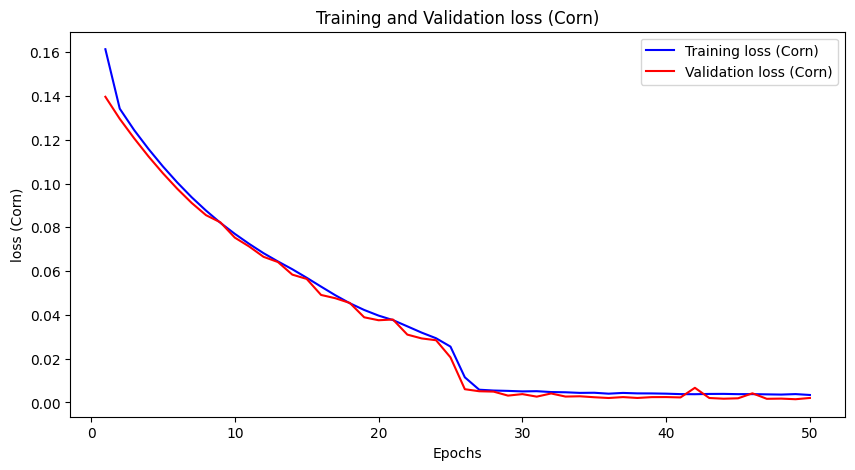

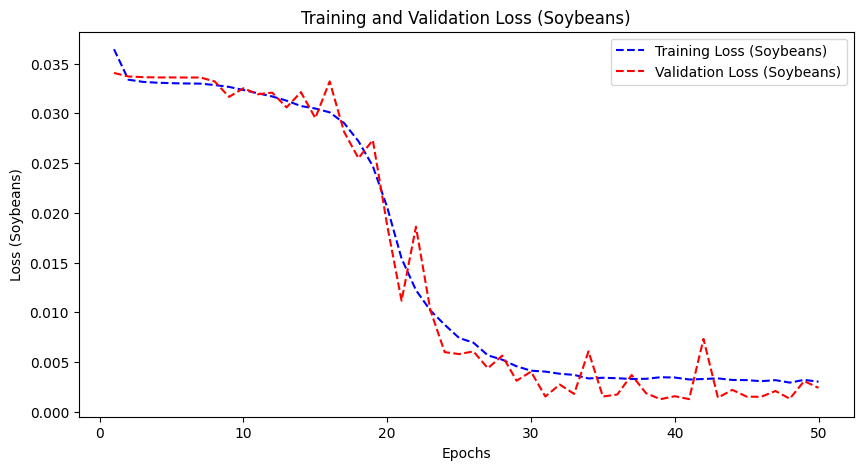

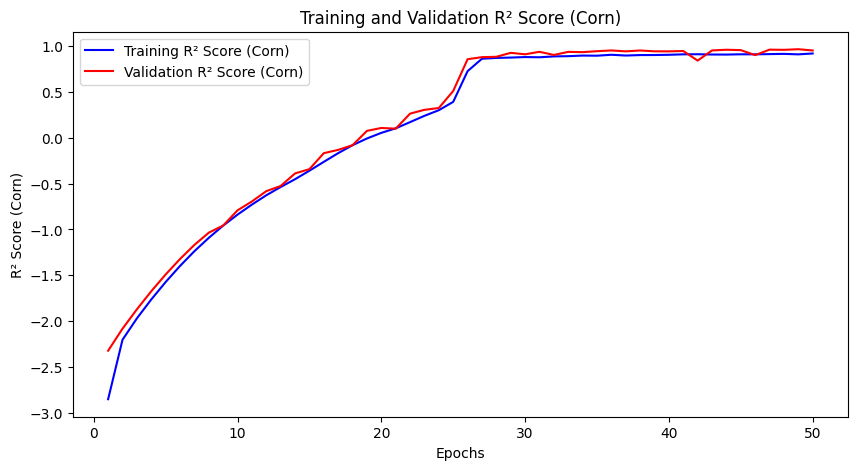

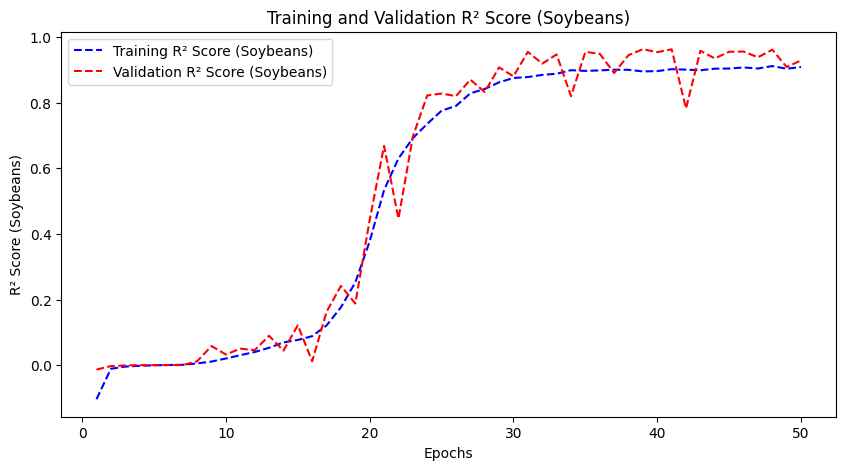

In [9]:
# num_epochs = 48
plot_metrics(train_losses1, train_losses2, val_losses1, val_losses2, train_r2_scores1, train_r2_scores2, val_r2_scores1, val_r2_scores2, num_epochs,base_dir)


In [10]:
# Test on MN22

Test Loss (Corn): 0.0033, Test Loss (Soybeans): 0.0033, Total Test Loss: 0.0066
Test R^2 Score (Corn): 0.9281, Test R^2 Score (Soybeans): 0.8785


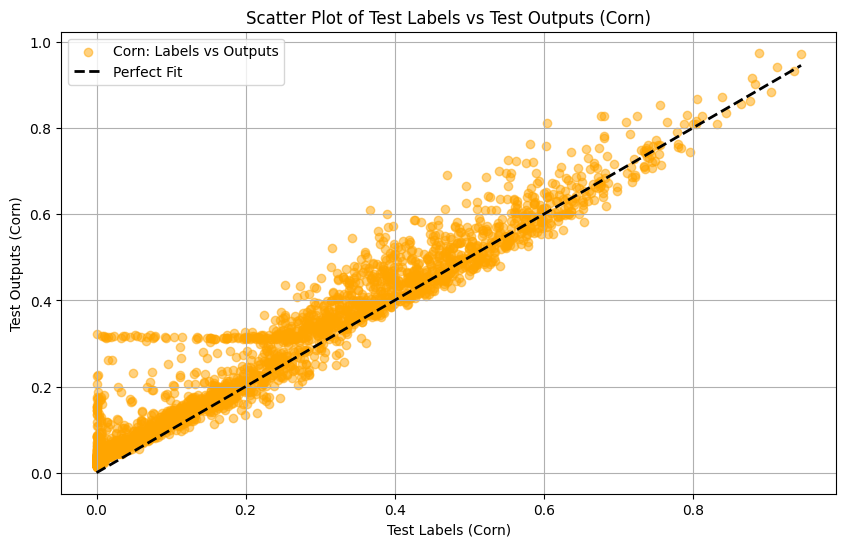

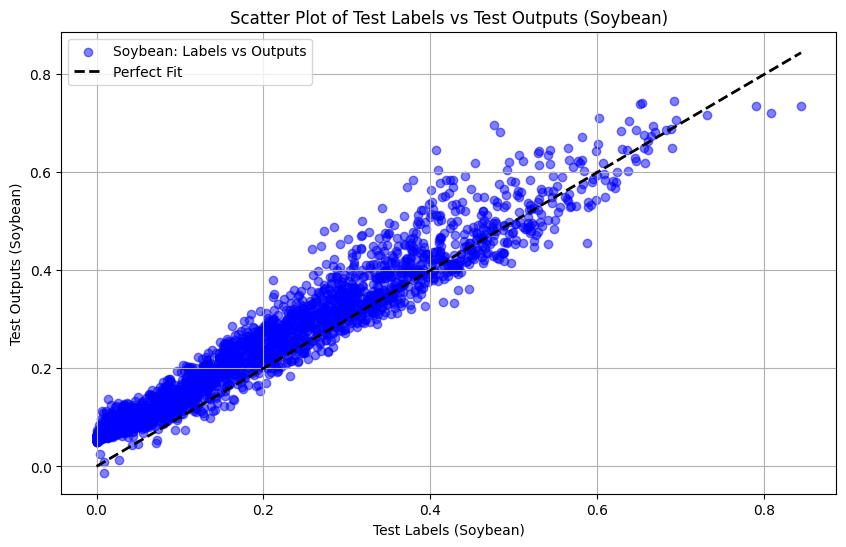

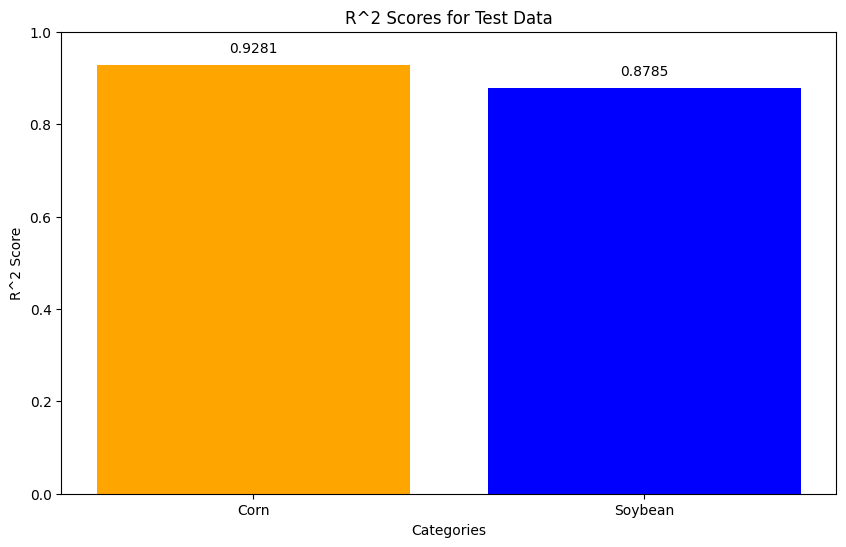

In [11]:
import torch
import os
import torch.nn as nn
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd

# Define the criterion and device
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode

    test_loss1 = 0.0
    test_loss2 = 0.0
    all_test_outputs = []
    all_test_labels = []

    with torch.no_grad():  # Ensure no gradients are computed in the testing phase
        for images, labels in test_loader:  # Iterate over batches of test data
            images, labels = images.to(device).float(), torch.stack(labels, dim=1).to(device).float()
            outputs = model(images)

            loss1 = criterion(outputs[:, 0], labels[:, 0])  # Compute loss for the first output
            loss2 = criterion(outputs[:, 1], labels[:, 1])  # Compute loss for the second output
            test_loss1 += loss1.item() * images.size(0)  # Accumulate the loss for the first output
            test_loss2 += loss2.item() * images.size(0)  # Accumulate the loss for the second output
            all_test_outputs.append(outputs.cpu().numpy())
            all_test_labels.append(labels.cpu().numpy())

    all_test_outputs = np.vstack(all_test_outputs)
    all_test_labels = np.vstack(all_test_labels)
    test_r2_score1 = r2_score(all_test_labels[:, 0], all_test_outputs[:, 0])
    test_r2_score2 = r2_score(all_test_labels[:, 1], all_test_outputs[:, 1])

    test_loss1 /= len(test_loader.dataset)  # Calculate average loss for the first output
    test_loss2 /= len(test_loader.dataset)  # Calculate average loss for the second output
    total_test_loss = test_loss1 + test_loss2  # Total test loss

    print(f"Test Loss (Corn): {test_loss1:.4f}, Test Loss (Soybeans): {test_loss2:.4f}, Total Test Loss: {total_test_loss:.4f}")
    print(f"Test R^2 Score (Corn): {test_r2_score1:.4f}, Test R^2 Score (Soybeans): {test_r2_score2:.4f}")

    # Save the labels and outputs to a CSV file
    df = pd.DataFrame({
        'Test Labels Corn': all_test_labels[:, 0],
        'Test Outputs Corn': all_test_outputs[:, 0],
        'Test Labels Soybean': all_test_labels[:, 1],
        'Test Outputs Soybean': all_test_outputs[:, 1]
    })
    df.to_csv('predictions_CNN_combined_MN22.csv', index=False)

    return all_test_labels, all_test_outputs, test_loss1, test_loss2, total_test_loss, test_r2_score1, test_r2_score2

import os

def plot_test_results(all_test_labels, all_test_outputs):
    # base_dir = 'checkpoints_CNN_multi_heads2'
    os.makedirs(base_dir, exist_ok=True)

    labels_x = all_test_labels[:, 0]
    labels_y = all_test_labels[:, 1]
    outputs_x = all_test_outputs[:, 0]
    outputs_y = all_test_outputs[:, 1]

    # Plot for the first output
    plt.figure(figsize=(10, 6))
    plt.scatter(labels_x, outputs_x, color='orange', alpha=0.5, label='Corn: Labels vs Outputs')
    plt.plot([labels_x.min(), labels_x.max()], [labels_x.min(), labels_x.max()], 'k--', linewidth=2, label='Perfect Fit')
    plt.title('Scatter Plot of Test Labels vs Test Outputs (Corn)')
    plt.xlabel('Test Labels (Corn)')
    plt.ylabel('Test Outputs (Corn)')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(base_dir, 'test_labels_vs_outputs_corn_49.png'))
    plt.show()

    # Plot for the second output
    plt.figure(figsize=(10, 6))
    plt.scatter(labels_y, outputs_y, color='blue', alpha=0.5, label='Soybean: Labels vs Outputs')
    plt.plot([labels_y.min(), labels_y.max()], [labels_y.min(), labels_y.max()], 'k--', linewidth=2, label='Perfect Fit')
    plt.title('Scatter Plot of Test Labels vs Test Outputs (Soybean)')
    plt.xlabel('Test Labels (Soybean)')
    plt.ylabel('Test Outputs (Soybean)')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(base_dir, 'test_labels_vs_outputs_soybean_49.png'))
    plt.show()

def plot_r2_scores(test_r2_score1, test_r2_score2):
    # base_dir = 'checkpoints_CNN_multi_heads'
    os.makedirs(base_dir, exist_ok=True)

    categories = ['Corn', 'Soybean']
    r2_scores = [test_r2_score1, test_r2_score2]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, r2_scores, color=['orange', 'blue'])
    plt.xlabel('Categories')
    plt.ylabel('R^2 Score')
    plt.title('R^2 Scores for Test Data')
    plt.ylim(0, 1)  # Assuming R^2 scores are between 0 and 1
    
    # Add the R^2 score values on top of the bars
    for bar, r2_score in zip(bars, r2_scores):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{r2_score:.4f}', ha='center', va='bottom')

    plt.savefig(os.path.join(base_dir, 'test_r2_scores_49.png'))
    plt.show()

def remove_module_prefix(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            new_state_dict[k[7:]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict


base_dir = 'checkpoints_CNN_combined_No_segmoid'


# Assuming 'test_loader' is defined, and the model is already loaded with the best weights
model = CNNRegressor().to(device)  # Use float tensors
checkpoint = torch.load('checkpoints_CNN_combined_No_segmoid/checkpoint_epoch_49.pth')
state_dict = remove_module_prefix(checkpoint['model_state_dict'])
model.load_state_dict(state_dict)

# Evaluate the model and plot the results
all_test_labels, all_test_outputs, test_loss1, test_loss2, total_test_loss, test_r2_score1, test_r2_score2 = evaluate_model(model, test_loader, criterion, device)
plot_test_results(np.array(all_test_labels), np.array(all_test_outputs))
plot_r2_scores(test_r2_score1, test_r2_score2)


In [8]:
# epoch 49

Test Loss (Corn): 0.0018, Test Loss (Soybeans): 0.0021, Total Test Loss: 0.0039
Test R^2 Score (Corn): 0.9599, Test R^2 Score (Soybeans): 0.9231


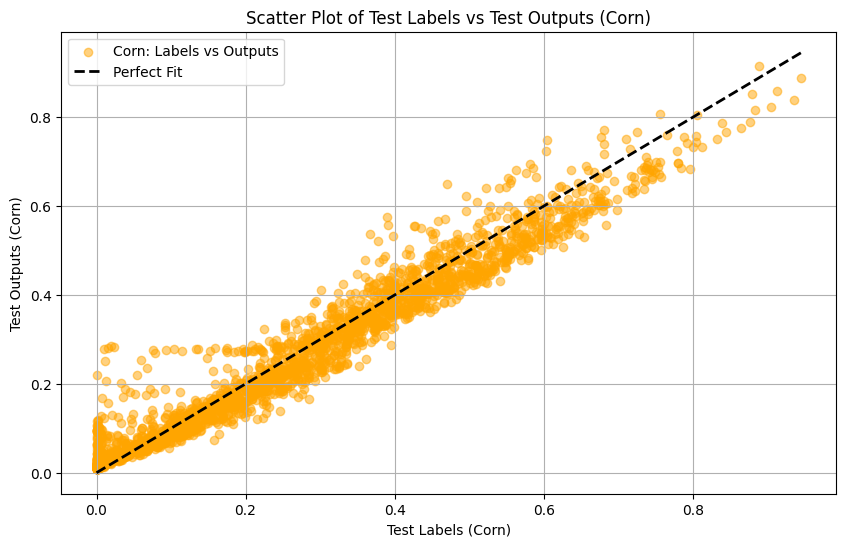

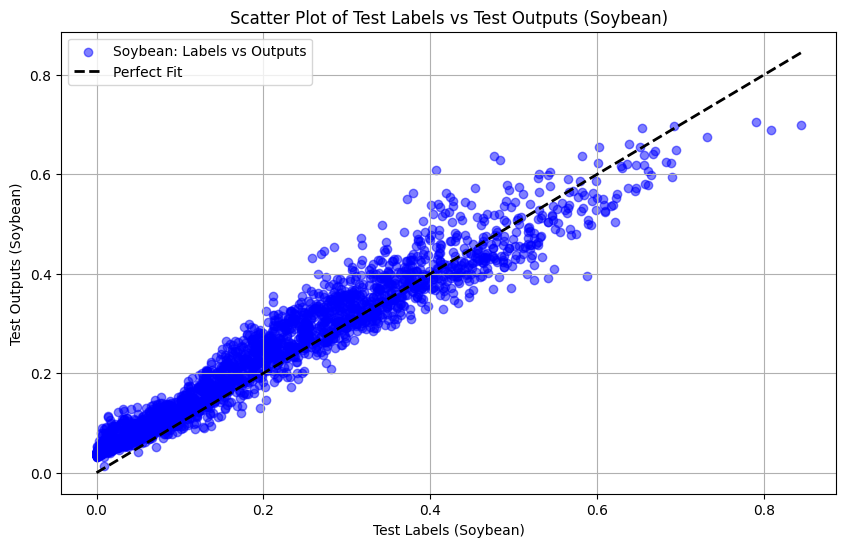

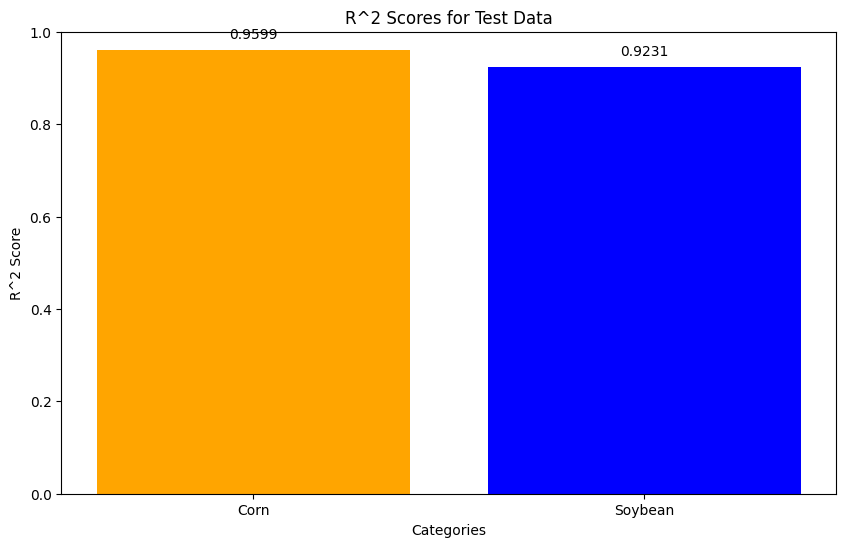

In [9]:
import torch
import os
import torch.nn as nn
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd

# Define the criterion and device
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode

    test_loss1 = 0.0
    test_loss2 = 0.0
    all_test_outputs = []
    all_test_labels = []

    with torch.no_grad():  # Ensure no gradients are computed in the testing phase
        for images, labels in test_loader:  # Iterate over batches of test data
            images, labels = images.to(device).float(), torch.stack(labels, dim=1).to(device).float()
            outputs = model(images)

            loss1 = criterion(outputs[:, 0], labels[:, 0])  # Compute loss for the first output
            loss2 = criterion(outputs[:, 1], labels[:, 1])  # Compute loss for the second output
            test_loss1 += loss1.item() * images.size(0)  # Accumulate the loss for the first output
            test_loss2 += loss2.item() * images.size(0)  # Accumulate the loss for the second output
            all_test_outputs.append(outputs.cpu().numpy())
            all_test_labels.append(labels.cpu().numpy())

    all_test_outputs = np.vstack(all_test_outputs)
    all_test_labels = np.vstack(all_test_labels)
    test_r2_score1 = r2_score(all_test_labels[:, 0], all_test_outputs[:, 0])
    test_r2_score2 = r2_score(all_test_labels[:, 1], all_test_outputs[:, 1])

    test_loss1 /= len(test_loader.dataset)  # Calculate average loss for the first output
    test_loss2 /= len(test_loader.dataset)  # Calculate average loss for the second output
    total_test_loss = test_loss1 + test_loss2  # Total test loss

    print(f"Test Loss (Corn): {test_loss1:.4f}, Test Loss (Soybeans): {test_loss2:.4f}, Total Test Loss: {total_test_loss:.4f}")
    print(f"Test R^2 Score (Corn): {test_r2_score1:.4f}, Test R^2 Score (Soybeans): {test_r2_score2:.4f}")

    # Save the labels and outputs to a CSV file
    df = pd.DataFrame({
        'Test Labels Corn': all_test_labels[:, 0],
        'Test Outputs Corn': all_test_outputs[:, 0],
        'Test Labels Soybean': all_test_labels[:, 1],
        'Test Outputs Soybean': all_test_outputs[:, 1]
    })
    df.to_csv('predictions_CNN_combined_MN22.csv', index=False)

    return all_test_labels, all_test_outputs, test_loss1, test_loss2, total_test_loss, test_r2_score1, test_r2_score2

import os

def plot_test_results(all_test_labels, all_test_outputs):
    # base_dir = 'checkpoints_CNN_multi_heads2'
    os.makedirs(base_dir, exist_ok=True)

    labels_x = all_test_labels[:, 0]
    labels_y = all_test_labels[:, 1]
    outputs_x = all_test_outputs[:, 0]
    outputs_y = all_test_outputs[:, 1]

    # Plot for the first output
    plt.figure(figsize=(10, 6))
    plt.scatter(labels_x, outputs_x, color='orange', alpha=0.5, label='Corn: Labels vs Outputs')
    plt.plot([labels_x.min(), labels_x.max()], [labels_x.min(), labels_x.max()], 'k--', linewidth=2, label='Perfect Fit')
    plt.title('Scatter Plot of Test Labels vs Test Outputs (Corn)')
    plt.xlabel('Test Labels (Corn)')
    plt.ylabel('Test Outputs (Corn)')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(base_dir, 'test_labels_vs_outputs_corn_49.png'))
    plt.show()

    # Plot for the second output
    plt.figure(figsize=(10, 6))
    plt.scatter(labels_y, outputs_y, color='blue', alpha=0.5, label='Soybean: Labels vs Outputs')
    plt.plot([labels_y.min(), labels_y.max()], [labels_y.min(), labels_y.max()], 'k--', linewidth=2, label='Perfect Fit')
    plt.title('Scatter Plot of Test Labels vs Test Outputs (Soybean)')
    plt.xlabel('Test Labels (Soybean)')
    plt.ylabel('Test Outputs (Soybean)')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(base_dir, 'test_labels_vs_outputs_soybean_49.png'))
    plt.show()

def plot_r2_scores(test_r2_score1, test_r2_score2):
    # base_dir = 'checkpoints_CNN_multi_heads'
    os.makedirs(base_dir, exist_ok=True)

    categories = ['Corn', 'Soybean']
    r2_scores = [test_r2_score1, test_r2_score2]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, r2_scores, color=['orange', 'blue'])
    plt.xlabel('Categories')
    plt.ylabel('R^2 Score')
    plt.title('R^2 Scores for Test Data')
    plt.ylim(0, 1)  # Assuming R^2 scores are between 0 and 1
    
    # Add the R^2 score values on top of the bars
    for bar, r2_score in zip(bars, r2_scores):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{r2_score:.4f}', ha='center', va='bottom')

    plt.savefig(os.path.join(base_dir, 'test_r2_scores_49.png'))
    plt.show()

def remove_module_prefix(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            new_state_dict[k[7:]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict


base_dir = 'checkpoints_CNN_combined_No_segmoid'


# Assuming 'test_loader' is defined, and the model is already loaded with the best weights
model = CNNRegressor().to(device)  # Use float tensors
checkpoint = torch.load('checkpoints_CNN_combined_No_segmoid/checkpoint_epoch_49.pth')
state_dict = remove_module_prefix(checkpoint['model_state_dict'])
model.load_state_dict(state_dict)

# Evaluate the model and plot the results
all_test_labels, all_test_outputs, test_loss1, test_loss2, total_test_loss, test_r2_score1, test_r2_score2 = evaluate_model(model, test_loader, criterion, device)
plot_test_results(np.array(all_test_labels), np.array(all_test_outputs))
plot_r2_scores(test_r2_score1, test_r2_score2)
